In [5]:
import librosa.display
import IPython.display as ipd
from glob import glob
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plot_melspectrogram(audio_data,zoom=0):
    y, sr = audio_data
    if zoom > 0:
        y = y[:zoom]
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=512, n_mels=128)
    # print(S.shape)
    S_DB = librosa.power_to_db(S, ref=np.max)
    print(S_DB.shape)
    # print(S_DB)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel Spectrogram')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.show()

In [1]:
from transformers import AutoFeatureExtractor, AutoModel
import torch
#pip intsll torch, transformers
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained('facebook/wav2vec2-base').to(device)
feature_extractor = AutoFeatureExtractor.from_pretrained('facebook/wav2vec2-base')

/Users/A117792292/anaconda3/envs/audioDiplomkaFreshLibrosa/lib/python3.10/site-packages/transformers/configuration_utils.py:302: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [4]:
audio_data = librosa.load("../mp3songs/SCHRANZ_2024_/FIRE IN THE BOOTH.mp3"
, sr=None)

In [5]:
audio_data

(array([-0.01547076, -0.00538017, -0.00153721, ..., -0.00111643,
        -0.01455899, -0.01199869], dtype=float32),
 44100)

In [6]:
audio_data[0].shape

(1310328,)

(128, 2560)


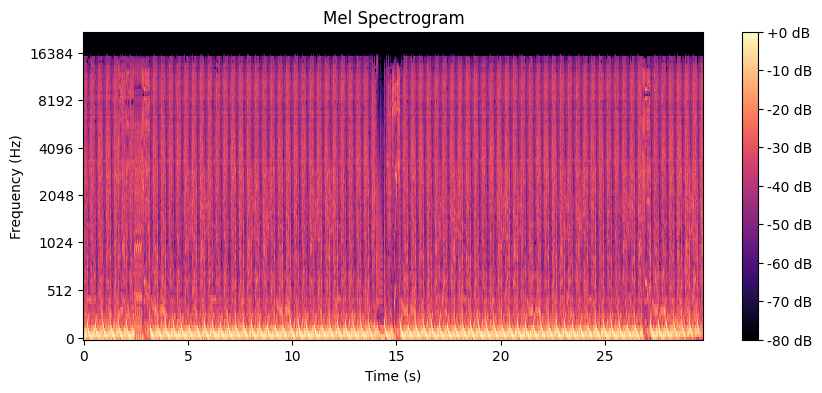

In [7]:
plot_melspectrogram(audio_data)

#SELECTING MOST IMPORTANT PART OF THE AUDIO

In [2]:
def select_strongest_8_seconds(y, sr, onset_env, beats):
    # Calculate the cumulative onset strength for each 8-second segment
    hop_length = 512
    frame_length = int(8 * sr / hop_length)
    onset_env_cumsum = np.cumsum(onset_env)
    max_strength = 0
    start_frame = 0

    for i in range(len(onset_env) - frame_length):
        strength = onset_env_cumsum[i + frame_length] - onset_env_cumsum[i]
        if strength > max_strength:
            max_strength = strength
            start_frame = i

    # Align the start of the 8-second segment with the nearest beat
    start_time = librosa.frames_to_time(start_frame, sr=sr, hop_length=hop_length)
    beat_times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)

    if len(beat_times) > 0:
        nearest_beat_time = min(beat_times, key=lambda x: abs(x - start_time))
        start_time = nearest_beat_time

    end_time = start_time + 8
    start_sample = int(start_time * sr)
    end_sample = int(end_time * sr)
    y_selected_seconds = y[start_sample:end_sample]
    return y_selected_seconds, start_time, end_time

In [19]:
onset_env = librosa.onset.onset_strength(y=audio_data[0], sr=audio_data[1], aggregate=np.median)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=audio_data[1], trim=True)
print(tempo, beats)
y_selected_seconds, start_time, end_time = select_strongest_8_seconds(audio_data[0], audio_data[1], onset_env, beats)
print(start_time, end_time)
print(y_selected_seconds.shape)

[161.49902344] [   3   32   64   96  128  161  193  225  257  290  322  355  387  419
  452  484  516  548  581  613  645  677  710  742  775  807  839  871
  904  936  968 1001 1033 1065 1097 1130 1162 1194 1227 1259 1290 1323
 1356 1388 1420 1453 1485 1517 1550 1582 1614 1646 1679 1711 1744 1776
 1808 1840 1873 1905 1937 1970 2002 2034 2067 2099 2131 2163 2196 2228
 2260 2293 2324 2357 2390 2422 2454 2486 2519 2551]
11.6215873015873 19.6215873015873
(352801,)


(128, 690)


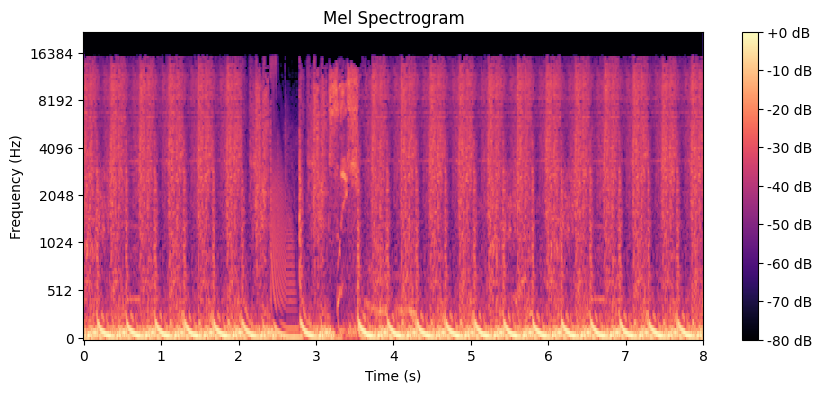

In [20]:
selected_audio_data=(y_selected_seconds, audio_data[1])

plot_melspectrogram(selected_audio_data)


##RESAMPLING

In [21]:
resampled_audio = librosa.resample(y=y_selected_seconds, orig_sr=audio_data[1], target_sr=16_000)

In [22]:
resampled_audio.shape

(128001,)

In [23]:
resampled_audio_data=(resampled_audio, 16_000)

(128, 251)


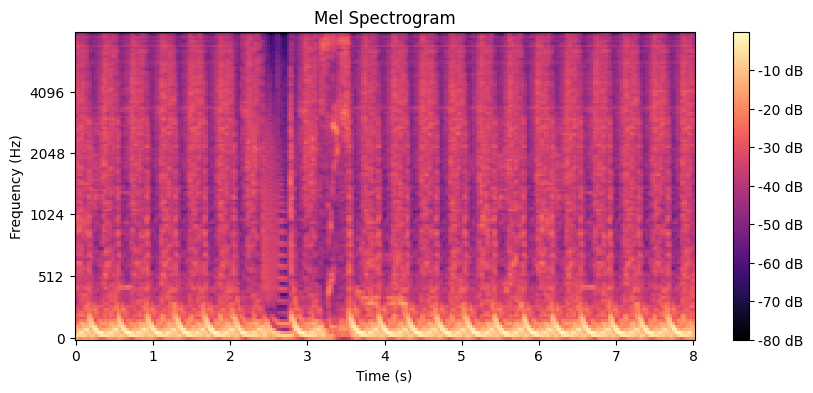

In [24]:
plot_melspectrogram(resampled_audio_data)

In [25]:
resampled_audio_data[0].shape

(128001,)

In [26]:
resampled_audio_reshaped = resampled_audio_data[0][None, :]
resampled_audio_reshaped.shape

(1, 128001)

In [27]:
ipd.Audio(resampled_audio_data[0], rate=16_000)


In [28]:
inputs = feature_extractor(
    resampled_audio_data[0], sampling_rate=feature_extractor.sampling_rate, return_tensors="pt",
    padding=True, return_attention_mask=True, truncation=True, max_length=16_000).to(device)

print(inputs['input_values'].shape)

torch.Size([1, 16000])


In [29]:
#TU JE .mean lebo chceme mat jeden embedding pre cely song nie vela embeddingov pre kusky songu
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state.mean(dim=1)
embeddings.shape

torch.Size([1, 768])

In [51]:
embeddings

tensor([[ 3.0848e-01,  7.3658e-02, -2.4574e-02,  2.5156e-01,  1.2174e-01,
         -7.3052e-02,  4.0709e-01, -1.8617e-01, -1.2136e-01, -2.4310e-01,
         -1.2301e-01, -3.1697e-01, -2.1202e-01,  1.7048e-01, -1.2368e-01,
         -3.5749e-01,  8.8788e-02,  1.2919e-01, -3.7402e-02, -2.0613e-02,
         -1.1852e-01, -1.9881e-01, -3.1866e-01,  3.8524e-01,  2.4459e-01,
         -1.6528e-01, -5.2163e-02, -1.0614e-01,  4.4556e-02, -2.5106e-01,
         -7.2383e-02, -1.8332e-04,  9.7917e-02,  9.1311e-02,  2.4322e-01,
         -1.6623e-01, -1.6928e-01, -9.6336e-02,  1.1218e-01,  5.5605e-02,
         -1.0956e-01,  5.6897e-01, -2.1131e-01, -4.4445e-01, -3.0630e-01,
          3.4147e-02,  2.2768e-02, -2.8884e-01,  1.0345e-01, -3.8293e-01,
         -2.5320e-01, -1.6318e-01,  5.9088e-01,  4.7485e-02,  1.4226e-01,
         -3.3723e-01, -4.1141e-02, -1.6552e-02,  4.7014e-01,  4.1640e-02,
         -6.0097e-01,  1.4777e-01,  8.8141e-02,  6.5240e-02, -2.4887e-01,
          4.1695e-02, -1.7663e-02, -6.

##EMBEDDING 8 SECONDS

In [4]:
import pandas as pd

csv_file = 'test_set_final_13main_59sub_genres.csv'

# Initialize the DataFrame
df = pd.read_csv(csv_file)
df

,name,artist,spotify_id,preview,img,danceability,energy,loudness,speechiness,acousticness,...,artist_id,genres,genres_str,main_genre,file_path,genre_array2,VGG_embeddings_8_seconds_base_13_genres_test,fine_tuned_13_genres_with_val_softmax_vggish_model_batch_size_5_test,fine_tuned_59_genres_with_val_sigmoid_vggish_model_multilabel_batch_size_5,base_open3l_model_test_data
0,Brown Noise 140 hz Sharp Q,Granular,1efbB8dNowPNwBU6HaHjup,https://p.scdn.co/mp3-preview/587cffc089799746...,https://i.scdn.co/image/ab67616d0000b273727265...,0.205,0.337,-37.221,0.0647,0.75100,...,1jfnMuDBl5OaAoU0VwLD8m,['sleep'],['sleep'],ambient,../mp3songs/48_genres_11_main_genres/Brown Noi...,[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.20768842101097107, 0.17027533054351807, 0....","[-1.7131984233856201, 1.8003138303756714, 0.26...","[-14.115251541137695, -7.341050148010254, -2.3...",[ 2.0042045 3.385865 2.2807853 0.486558...
1,Survival Tactics,Joey Bada$$,4pNT8XTKWb2vhcsqwzdXCT,https://p.scdn.co/mp3-preview/89f912f9bbd2af71...,https://i.scdn.co/image/ab67616d0000b273fcd372...,0.530,0.843,-2.271,0.3900,0.42800,...,2P5sC9cVZDToPxyomzF1UH,"['hip hop', 'rap']","['hip hop', 'rap']",rap,../mp3songs/48_genres_11_main_genres/Survival ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.5984508991241455, -0.21273860335350037, 0....","[-4.477705478668213, -2.5627753734588623, -2.5...","[-4.634706020355225, -2.2025468349456787, -2.5...",[2.7665234 2.2206402 2.4165297 2.279251 1...
2,That Day Will Come,Capleton,6D4eMFcg3DquhNOQsNanQk,https://p.scdn.co/mp3-preview/d33eccef67aaf6ac...,https://i.scdn.co/image/ab67616d0000b27352630f...,0.672,0.839,-5.034,0.1140,0.06740,...,21J3YJTyq1biE3SvSNjzuf,"['reggae', 'roots reggae']","['reggae', 'roots reggae']",reggae,../mp3songs/48_genres_11_main_genres/That Day ...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.6541938781738281, 0.03160589933395386, 0.2...","[-4.383584022521973, -2.044909715652466, -1.62...","[-5.128568172454834, -2.1408400535583496, -2.6...",[2.2732286 2.584271 3.2119744 2.348352 1...
3,Already Gone,Kelly Clarkson,4fq2YUONcgrCJ2SPndSeKC,https://p.scdn.co/mp3-preview/660bd02563cebe61...,https://i.scdn.co/image/ab67616d0000b2737ed879...,0.209,0.872,-2.996,0.0757,0.21700,...,3BmGtnKgCSGYIUhmivXKWX,"['dance pop', 'pop']","['dance pop', 'pop']",pop,../mp3songs/48_genres_11_main_genres/Already G...,[0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.4340738356113434, -0.13108360767364502, 0....","[-3.3959813117980957, -1.1046748161315918, -1....","[-5.52520751953125, -1.0195895433425903, -0.75...",[2.3422306 2.3426332 2.685641 2.38519 2...
4,The Drugs,The Holdup,6CTxqx9pxaoOxOYZSbsqDc,https://p.scdn.co/mp3-preview/c544ea6c0d9720a9...,https://i.scdn.co/image/ab67616d0000b273a580ae...,0.723,0.810,-3.983,0.0338,0.03370,...,1gwTohHbTpE3qdPyDvnOEu,['reggae fusion'],['reggae fusion'],reggae,../mp3songs/48_genres_11_main_genres/The Drugs...,[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0...,"[-1.0772324800491333, 0.011838555335998535, 0....","[-6.385115623474121, -1.9373447895050049, -2.0...","[-6.066783905029297, -1.9855862855911255, -1.5...",[2.1347637 2.1387303 3.246513 2.245867 1...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,"The Good, the Bad and the Dirty",Panic! At The Disco,5eoZTdiq4C4aoEfUwAN0ha,https://p.scdn.co/mp3-preview/f37091eef36c052b...,https://i.scdn.co/image/ab67616d0000b27323152d...,0.531,0.825,-5.333,0.0545,0.00191,...,20JZFwl6HVl6yg8a4H3ZqK,['pop'],['pop'],pop,"../mp3songs/48_genres_11_main_genres/The Good,...",[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0...,"[-0.633353590965271, -0.1372760832309723, 0.10...","[-4.58098030090332, -2.0702669620513916, -2.02...","[-5.9073100090026855, -2.2739641666412354, -3....",[2.212627 2.329846 2.4827034 2.4413834 1...
840,The End Is Where We Begin,Thousand Foot Krutch,1Ou0kPQcfXuLVYUKV8KUox,https://p.scdn.co/mp3-preview/5037771d0b7498bc...,https://i.scdn.co/image/ab67616d0000b273405821.

In [8]:
import pandas as pd
from glob import glob
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from tqdm import tqdm
# Initialize Qdrant client
client = QdrantClient(url="http://localhost:6333")

# List all CSV files in the playlist_datasets directory
csv_files = ["test_set_final_13main_59sub_genres.csv"]

# Global counter for unique IDs
global_id = 0

# Function to generate embeddings for a single audio file
def generate_embeddings_for_file(file_path):
    audio_data = librosa.load(file_path, sr=None)

    onset_env = librosa.onset.onset_strength(y=audio_data[0], sr=audio_data[1], aggregate=np.median)
    tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=audio_data[1], trim=True)
    print(tempo, beats)
    y_selected_seconds, start_time, end_time = select_strongest_8_seconds(audio_data[0], audio_data[1], onset_env, beats)
    #SELECTING ONLY 8 SECONDS
    selected_audio_data=(y_selected_seconds, audio_data[1])

    audio_reshaped = selected_audio_data[0][None, :]
    resampled_audio = librosa.resample(y=audio_reshaped, orig_sr=audio_data[1], target_sr=16_000)

    inputs = feature_extractor(
        resampled_audio[0], sampling_rate=16_000, return_tensors="pt", padding=True,
        return_attention_mask=True, max_length=16_000, truncation=True
    ).to(device)

    with torch.no_grad():
        pooled_embeddings = model(**inputs).last_hidden_state.mean(dim=1)

    return pooled_embeddings.cpu().numpy()

# Function to process the entire DataFrame
def process_audio_df(df, file_path_column):
    df['base_wav2vec_transformer_model_test_data'] = df[file_path_column].apply(generate_embeddings_for_file)
    return df

# Function to process each CSV file and upsert data into Qdrant
def process_all_csv_files():
    global global_id
    for csv_file in tqdm(csv_files):
        # Read the CSV file into a DataFrame
        audio_df = pd.read_csv(csv_file)

        # Process the DataFrame
        audio_df = process_audio_df(audio_df, 'file_path')

        # Generate points for upsert
        points = [
            PointStruct(id=global_id + index, vector=row['base_wav2vec_transformer_model_test_data'].flatten(), payload=row.drop(['base_wav2vec_transformer_model_test_data', 'base_open3l_model_test_data', 'VGG_embeddings_8_seconds_base_13_genres_test','fine_tuned_13_genres_with_val_softmax_vggish_model_batch_size_5_test','fine_tuned_59_genres_with_val_sigmoid_vggish_model_multilabel_batch_size_5']).to_dict())
            for index, row in audio_df.iterrows()
        ]

        # Update the global ID counter
        global_id += len(audio_df)

        # Upsert data into the collection
        operation_info = client.upsert(
            collection_name="base_wav2vec_transformer_model_test_data",
            wait=True,
            points=points,
        )
        print(f"Processed and upserted data from: {csv_file}")
        print(operation_info)

# Call the function to process and upsert data from all CSV files


In [9]:
process_all_csv_files()


  0%|          | 0/1 [00:00<?, ?it/s]

0.0 []


2025-03-19 13:12:50.045674: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[67.11647727] [ 160  229  305  371  440  499  570  644  729  794  867  942 1016 1082
 1147 1223 1304 1376 1453 1534 1619 1692 1767 1844 1909 1975 2039 2109
 2183 2260 2337 2413 2494 2574]
[151.99908088] [   8   42   75  109  143  176  210  243  277  311  345  378  412  446
  479  513  546  580  614  648  681  715  749  782  816  850  883  917
  951  985 1018 1052 1086 1120 1153 1187 1221 1254 1288 1321 1355 1389
 1423 1456 1490 1524 1557 1591 1624 1658 1692 1726 1759 1793 1827 1860
 1894 1928 1961 1995 2029 2062 2096 2130 2164 2197 2231 2265 2299 2332
 2366 2399 2433 2467 2501]
[147.65625] [ 154  189  223  257  294  329  364  400  433  469  504  539  573  607
  641  679  713  747  781  819  853  890  923  958  992 1028 1062 1097
 1132 1167 1202 1238 1272 1305 1343 1376 1411 1446 1482 1518 1551 1586
 1622 1656 1690 1727 1762 1798 1830 1866 1902 1935 1970 2007 2042 2076
 2109 2144 2176 2214 2249 2283 2319 2355 2389 2424 2459 2497]
[156.60511364] [ 142  176  209  242  275  309  343  376  

100%|██████████| 1/1 [10:28<00:00, 628.13s/it]

Processed and upserted data from: test_set_final_13main_59sub_genres.csv
operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>


30SEC EMBEDDINGS

In [34]:
import pandas as pd
from glob import glob
from qdrant_client import QdrantClient
from qdrant_client.models import PointStruct
from tqdm import tqdm
# Initialize Qdrant client
client = QdrantClient(url="http://localhost:6333")

# List all CSV files in the playlist_datasets directory
csv_files = ["spotify_songs_stratified_first_genre_with_paths.csv"]

# Global counter for unique IDs


# Function to generate embeddings for a single audio file
def generate_embeddings_for_file(file_path):
    audio_data = librosa.load(file_path, sr=None)
    #
    # onset_env = librosa.onset.onset_strength(y=audio_data[0], sr=audio_data[1], aggregate=np.median)
    # tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=audio_data[1], trim=True)
    # print(tempo, beats)
    # y_selected_seconds, start_time, end_time = select_strongest_8_seconds(audio_data[0], audio_data[1], onset_env, beats)
    # #SELECTING ONLY 8 SECONDS
    # selected_audio_data=(y_selected_seconds, audio_data[1])

    audio_reshaped = audio_data[0][None, :]
    resampled_audio = librosa.resample(y=audio_reshaped, orig_sr=audio_data[1], target_sr=16_000)

    inputs = feature_extractor(
        resampled_audio[0], sampling_rate=16_000, return_tensors="pt", padding=True,
        return_attention_mask=True, max_length=16_000, truncation=True
    ).to(device)

    with torch.no_grad():
        pooled_embeddings = model(**inputs).last_hidden_state.mean(dim=1)

    return pooled_embeddings.cpu().numpy()

# Function to process the entire DataFrame
def process_audio_df(df, file_path_column):
    embeddings = []
    for file_path in tqdm(df[file_path_column], desc="Generating embeddings"):
        embedding = generate_embeddings_for_file(file_path)
        embeddings.append(embedding)
    df['transformer_embeddings_30_seconds'] = embeddings
    return df

# Function to process each CSV file and upsert data into Qdrant
def process_all_csv_files(batch_size=100):
    for csv_file in tqdm(csv_files):
        # Read the CSV file into a DataFrame
        audio_df = pd.read_csv(csv_file)

        # Process the DataFrame
        audio_df = process_audio_df(audio_df, 'file_path')

        # Generate points for upsert
        points = [
            PointStruct(id=index, vector=row['transformer_embeddings_30_seconds'].flatten(), payload=row.drop('transformer_embeddings_30_seconds').to_dict())
            for index, row in audio_df.iterrows()
        ]


        for i in range(0, len(points), batch_size):
            batch_points = points[i:i + batch_size]
            operation_info = client.upsert(
                collection_name="transformer_embeddings_30_seconds",
                wait=True,
                points=batch_points,
            )
            print(f"Upserted batch {i // batch_size + 1} from: {csv_file}")
            print(operation_info)

        # Save the DataFrame with embeddings
        audio_df.to_csv(csv_file.replace(".csv", "_with_embeddings.csv"), index=False)
        print(f"Saved DataFrame with embeddings to: {csv_file.replace('.csv', '_with_embeddings.csv')}")
# Call the function to process and upsert data from all CSV files


In [35]:
process_all_csv_files()

Generating embeddings: 100%|██████████| 4315/4315 [13:59<00:00,  5.14it/s]


Upserted batch 1 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=0 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 2 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=1 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 3 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=2 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 4 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=3 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 5 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=4 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 6 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=5 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 7 from: spotify_songs_stratified_first_genre_with_paths.csv
operation_id=6 status=<UpdateStatus.COMPLETED: 'completed'>
Upserted batch 8 from: spotify_songs_stratified_first_g

100%|██████████| 1/1 [14:34<00:00, 874.55s/it]

Saved DataFrame with embeddings to: spotify_songs_stratified_first_genre_with_paths_with_embeddings.csv


In [60]:
import pandas as pd
import os
from glob import glob

def drop_embeddings_column_from_all_csvs():
    csv_files = glob('../playlist_datasets/*.csv')


    for csv_file in csv_files:
        # Read the CSV file into a DataFrame
        df = pd.read_csv(csv_file)

        # Drop the embeddings column if it exists
        if 'embeddings' in df.columns:
            df = df.drop(columns=['embeddings'])

        # Save the modified DataFrame back to the CSV file
        df.to_csv(csv_file, index=False)
        print(f"Processed and saved: {csv_file}")

# Example usage
drop_embeddings_column_from_all_csvs()

Processed and saved: ../playlist_datasets/Liquid_Drum_and_Bass.csv
Processed and saved: ../playlist_datasets/SCHRANZ_2024_.csv
Processed and saved: ../playlist_datasets/Groove_Techno.csv
Processed and saved: ../playlist_datasets/Hardcore_Techno_Hardstyle.csv
Processed and saved: ../playlist_datasets/HARD_TECHNO.csv
Processed and saved: ../playlist_datasets/Neurofunk_Drum_and_Bass.csv
Processed and saved: ../playlist_datasets/tekkno.csv
Processed and saved: ../playlist_datasets/Jump-Up_Drum_and_Bass.csv
Processed and saved: ../playlist_datasets/90s_House_Classics.csv
Processed and saved: ../playlist_datasets/TECHNO_BUNKER.csv
Processed and saved: ../playlist_datasets/ACID!_Best_Acid_Techno_Mix.csv
